Отдельные моменты в первоначальном задании были мне непонятны, поэтому я также отталикивался от дополнительных комментариев преподавателя

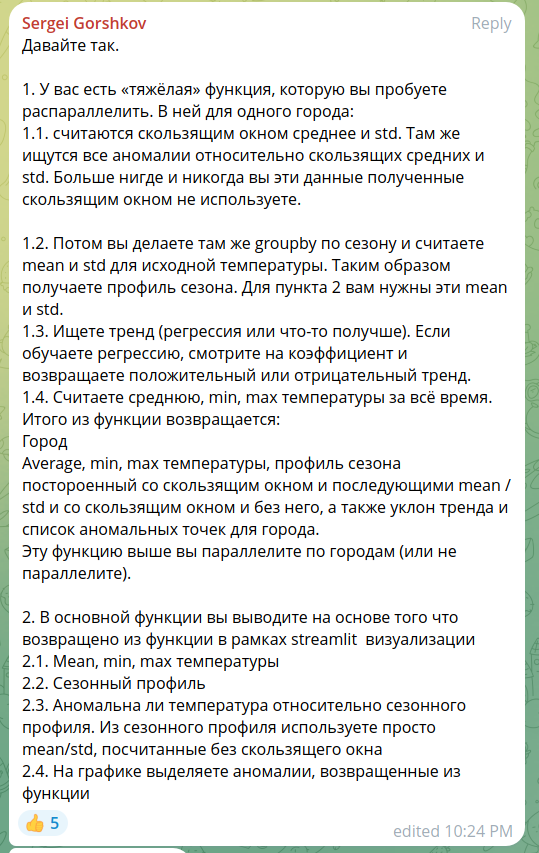

In [110]:
# Импортируем нужные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from multiprocessing import Pool, cpu_count
import time
import datetime
import requests
import json

In [3]:
# Считываем данные
data = pd.read_csv('temperature_data.csv')

Поскольку далее мы будем сравнитвать производительность последовательной и параллельной обработки данных, напишем декоратор для измерения времени выполнения функции, в который будем оборачивать интересующие нас функции

In [88]:
def exec_time_calc_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()  # Начало измерения времени
        result = func(*args, **kwargs)  # Вызов декорируемой функции
        end_time = time.time()  # Конец измерения времени
        total_time = end_time - start_time  # Подсчет времени выполнения
        print(f"Время выполнения функции '{func.__name__}': {total_time:.4f} секунд")
        return result  # Возврат результата декорируемой функции
    wrapper.original_function = func # Оставим возможность вызвать оригинальную функцию без декоратора
    return wrapper

Вычисление основных требуемых в задании параметров:
- скользящее среднее с окном в 30 дней
- скользящее стандартное отклонение с окном в 5 дней
- Средняя температура (без сглаживания)
- Стандартное отклонение
- Минимальная температура
- Максимальная температура
- Направление тренда изменения температур
- Список аномальных значений температуры
- Список дат, в которые наблюдались аномальные температуры

In [95]:
@exec_time_calc_decorator # Декорируем функцию для подсчета времени ее выполнения
def temperature_analysis(data: pd.DataFrame, city: str)-> dict:
    """
    Функция для расчета описательных статистик на основании исторических данных о температуре
    """

    data = data.copy()
    # Преобразование даты в формат datetime
    data['timestamp'] = pd.to_datetime(data['timestamp'])  
    # Устанавливаем время в качестве индекса
    data.set_index('timestamp', inplace=True)  
    # Отфильтруем данные для заданного города
    data = data[data['city'] == city]
    # Вычисление скользящего среднего с окном в 30 дней для каждого сезона
    data['moving_average'] = data.groupby('season')['temperature'].transform(lambda x: x.rolling(window='30D', min_periods=1).mean())
    # Получение средних значений скользящего среднего для каждого сезона
    seasonal_mov_avg = data.groupby('season')['moving_average'].last()  # Получаем последнее значение для каждого сезона
    # Вычисление стандартного отклонения c окном 5 дней для каждого сезона
    data['moving_std_dev'] = data.groupby('season')['temperature'].transform(lambda x: x.rolling(window='5D').std())
    seasonal_mov_std = data.groupby('season')['moving_std_dev'].last()  # Получаем последнее значение для каждого сезона    
    # Получение "профиля сезона". 
    data['mean_temp'] = data.groupby(['season'])['temperature'].transform('mean')
    seasonal_mean_temp = data.groupby('season')['mean_temp'].last()

    data['std_temp'] = data.groupby(['season'])['temperature'].transform('std')
    seasonal_std_temp = data.groupby('season')['std_temp'].last()
    # Вычисление минимальной температуры для каждого сезона
    data['min_temp'] = data.groupby(['season'])['temperature'].transform('min')
    seasonal_min_temp = data.groupby('season')['min_temp'].last()
    # Вычисление максимальной температуры для каждого сезона
    data['max_temp'] = data.groupby(['season'])['temperature'].transform('max')
    seasonal_max_temp = data.groupby('season')['max_temp'].last()

    # определим функцию для определения является ли температура аномальной
    data.reset_index(inplace=True)
    anomalous_temp = []
    anomalous_temp_dates = []
    for i in range(len(data.index)):
        if data.loc[i, 'temperature'] < data.loc[i, 'mean_temp'] - 2 * data.loc[i, 'std_temp'] or \
           data.loc[i, 'temperature'] > data.loc[i, 'mean_temp'] + 2 * data.loc[i, 'std_temp']:
            anomalous_temp.append(data.loc[i, 'temperature']) 
            anomalous_temp_dates.append(data.loc[i, 'timestamp'])     
    
    # Определение тренда изменения температуры
    # Преобразование timestamp в числовой формат (количество дней с начальной даты)
    data['days_since_start'] = np.arange(len(data))
    X = data[['days_since_start']].values  # Признак (дни)
    y = data['temperature'].values         # Целевая переменная (температура)
    # Обучение модели линейной регрессии
    model = LinearRegression()
    model.fit(X, y)    
    # Предсказание тренда
    y_pred = model.predict(X)

    # Определение направления тренда (положительный или отрицательный)
    if model.coef_ < 0:
        trend_dir = 'negative'
    elif model.coef_ > 0:
        trend_dir = 'positive'
    else:
        trend_dir = 'constant'

    # Собираем все результаты воедино 
    # (в словарь, т.к. у нас получются данные разных типов, в том числе списки, которые неудобно хранить в датафрейме)
    output_summary = {}
    seasons = ['autumn', 'spring', 'summer', 'winter']    
    for season, roll_avg, roll_std, mean, std, min, max in zip(seasons,
                                                          seasonal_mov_avg,
                                                          seasonal_mov_std,
                                                          seasonal_mean_temp,
                                                          seasonal_std_temp,
                                                          seasonal_min_temp,
                                                          seasonal_max_temp):
        
        output_summary[season+'_Скользящее среднее'] = roll_avg
        output_summary[season+'_Скользящее станд. отклонение'] = roll_std
        output_summary[season+'_Средняя температура'] = mean
        output_summary[season+'_Станд. отклонение'] = std
        output_summary[season+'_Мин. температура'] = min
        output_summary[season+'_Мaкс. температура'] = max
        output_summary['Направление тренда'] = trend_dir
        output_summary['Точки тренда'] = y_pred
        output_summary['Все температуры'] = y
        output_summary['Aномальные температуры'] = anomalous_temp        
        output_summary['Даты'] = data['timestamp'] 
        output_summary['Даты аномальных температур'] = anomalous_temp_dates        

    return output_summary

Поскольку функция `temperature_analysis` возвращает результаты в виде словаря, который неудобен для наглядного представления результатов, напишем еще одну функцию, которая преобразует часть данных, касающихся описательных статистик в датафрейм

In [96]:
def print_results(output_summary: dict) -> pd.DataFrame:
    """
    Функция для преобразования результатов анализа исторических данных в датафрейм
    """

    # Создаем словарь
    dict_for_print = {'winter': [], 'spring': [], 'summer': [], 'autumn': []}

    # Проходимся по словарю output_summray и вычленяем данные по каждому сезону
    for key in output_summary.keys():
        if key.startswith('winter'):          
            dict_for_print['winter'].append(output_summary[key])
        elif key.startswith('spring'):            
            dict_for_print['spring'].append(output_summary[key])
        elif key.startswith('summer'):            
            dict_for_print['summer'].append(output_summary[key])
        elif key.startswith('autumn'):              
            dict_for_print['autumn'].append(output_summary[key])

    # Опишем индексы для будущего датафрейма
    indexes = ['Скользящее среднее', 
               'Скользящее станд. отклонение', 
               'Средняя температура', 
               'Станд. отклонение', 
               'Мин. температура', 
               'Мaкс. температура' ]
    
    # Собираем все в датафрейм
    output_df = pd.DataFrame(dict_for_print , index=indexes)
    return output_df

Проверим работу написанных функций

In [125]:
temp_res = temperature_analysis(data, 'New York')

Время выполнения функции 'temperature_analysis': 0.1553 секунд


In [126]:
print_results(temp_res)

,winter,spring,summer,autumn
Скользящее среднее,1.057636,9.957108,25.454840,14.822120
Скользящее станд. отклонение,8.625491,5.244146,3.490851,5.333122
Средняя температура,0.108410,9.717220,25.021292,15.146720
Станд. отклонение,5.129209,5.072875,4.951442,4.920008
Мин. температура,-15.476055,-5.515163,11.052496,0.638614
Мaкс. температура,19.007757,24.168607,40.244865,30.477022


Теперь попробуем распараллелить вычисления внутри функции `temperature_analysis`. Поскольку мы имеем CPU-bound задачу, имеет смысл попробовать применить многопроцессность. Например, т.к. у нас обрабатывается 4 сезона, логично сделать обработку данных по каждому сезону независимо

In [102]:
def process_season(data: pd.DataFrame, season: str) -> dict:
    """
    Функция расчета описательных статистик для отдельного сезона
    """

    # Фильтруем данные для текущего сезона
    season_data = data[data['season'] == season].copy()

    # Скользящее среднее и стандартное отклонение
    season_data['moving_average'] = season_data['temperature'].rolling(window='30D', min_periods=1).mean()
    season_data['moving_std_dev'] = season_data['temperature'].rolling(window='5D').std()

    # Средняя, стандартное отклонение, минимум и максимум
    mean_temp = season_data['temperature'].mean()
    std_temp = season_data['temperature'].std()
    min_temp = season_data['temperature'].min()
    max_temp = season_data['temperature'].max()

    # Аномальные температуры
    anomalous_temps = season_data[
        (season_data['temperature'] < mean_temp - 2 * std_temp) |
        (season_data['temperature'] > mean_temp + 2 * std_temp)
    ]

    # Определение тренда изменения температуры
    season_data['days_since_start'] = np.arange(len(season_data))
    X = season_data[['days_since_start']].values
    y = season_data['temperature'].values

    model = LinearRegression()
    model.fit(X, y)
    trend_dir = 'positive' if model.coef_ > 0 else 'negative' if model.coef_ < 0 else 'constant'

    # Сохраняем результаты в словарь словарей
    return {
        'season': season,
        'moving_average': season_data['moving_average'].iloc[-1] if not season_data.empty else None,
        'moving_std_dev': season_data['moving_std_dev'].iloc[-1] if not season_data.empty else None,
        'mean_temp': mean_temp,
        'std_temp': std_temp,
        'min_temp': min_temp,
        'max_temp': max_temp,
        'trend_dir': trend_dir,
        'trend_points': model.predict(X).tolist(),
        'anomalous_temps': anomalous_temps['temperature'].tolist(),
        'anomalous_dates': anomalous_temps.index.tolist()
    }

@exec_time_calc_decorator # Декорируем функцию для подсчета времени выполнения
def temperature_analysis_parallel(data: pd.DataFrame, city: str):
    """
    Функция запускающая параллельную обработку данных для каждого сезона и возвращающая общий результат по всем сезонам
    """
    # Подготовка данных
    data = data.copy()
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data.set_index('timestamp', inplace=True)
    data = data[data['city'] == city]

    # Список сезонов
    seasons = data['season'].unique()

    # Используем multiprocessing для обработки каждого сезона
    with Pool(processes=cpu_count()) as pool:
        results = pool.starmap(process_season, [(data, season) for season in seasons])

    # Собираем результаты
    output_summary = {res['season']: res for res in results}
    return output_summary

В отличие от функции `temperature_analysis` функция `temperature_analysis_parallel` написана с использованием ChatGPT, благодаря чему ее код выглядит гораздо изящнее и читабельнее. Она возвращает значения в несколько ином виде, нежели функция `temperature_analysis`, поэтому напишем отдельную функцию для преобразования этих данных в датафрейм. \
Ранее написанного "уродца" - функцию `temperature_analysis` не будем удалять как пример того, как **не надо писать код**. Кроме того, она работает не хуже, как покаажут замеры далее.

In [103]:
def print_results_parallel(output_summary: dict) -> pd.DataFrame:
    """
    Функция для преобразования результатов анализа исторических данных, полученных при помощи Multiprocessing, в датафрейм
    """

    # Инициализируем словарь для формирования DataFrame
    result = {
        'Параметр': [],
        'winter': [],
        'spring': [],
        'summer': [],
        'autumn': []
    }

    # Список параметров, которые нужно извлечь
    parameters = ['moving_average',
                  'moving_std_dev', 
                  'mean_temp', 
                  'std_temp', 
                  'min_temp', 
                  'max_temp'
                  ]

    # Маппинг параметров на их читаемые названия
    param_names = {
        'moving_average': 'Скользящее среднее',
        'moving_std_dev': 'Скользящее станд. отклонение',        
        'mean_temp': 'Средняя температура',
        'std_temp': 'Станд. отклонение',
        'min_temp': 'Мин. температура',
        'max_temp': 'Макс. температура',        
    }

    # Заполняем результат
    for param in parameters:
        result['Параметр'].append(param_names[param])
        for season in ['winter', 'spring', 'summer', 'autumn']:
            result[season].append(output_summary[season][param])

    # Преобразуем словарь в DataFrame
    df = pd.DataFrame(result)

    return df

Проверим работу функции с параллельной обработкой данных

In [104]:
temp_res_parallel = temperature_analysis_parallel(data, 'New York')

Время выполнения функции 'temperature_analysis_parallel': 0.1813 секунд


In [105]:
print_results_parallel(temp_res)

,Параметр,winter,spring,summer,autumn
0,Скользящее среднее,1.057636,9.957108,25.454840,14.822120
1,Скользящее станд. отклонение,8.625491,5.244146,3.490851,5.333122
2,Средняя температура,0.108410,9.717220,25.021292,15.146720
3,Станд. отклонение,5.129209,5.072875,4.951442,4.920008
4,Мин. температура,-15.476055,-5.515163,11.052496,0.638614
5,Макс. температура,19.007757,24.168607,40.244865,30.477022


Как видим, функции выдают практически идентичный результат, при этом время выполнения также примерно одинаково

Вызовем написанные ранее функции для всех городов

In [108]:
# Последовательно вызовем функцию temperature_analysis для каждого из выбранных городов
cities = ['New York', 'London', 'Paris', 'Tokyo', 'Moscow', 'Sydney', 'Berlin', 'Beijing', 'Rio de Janeiro', 'Dubai', 'Los Angeles', 'Singapore', 'Mumbai', 'Cairo', 'Mexico City']

start_time = time.time()
for city in cities:
    temperature_analysis.original_function(data, city) # раздекорируем функцию, чтобы убрать ненужные print
end_time = time.time()
total_time = end_time - start_time
print(f'Общее время последовательной обработки данных по 15 городам составило: {total_time:.4f} секунд')

Общее время последовательной обработки данных по 15 городам составило: 1.7538 секунд


In [109]:
start_time = time.time()
for city in cities:
    temperature_analysis_parallel.original_function(data, city)
end_time = time.time()
total_time = end_time - start_time
print(f'Общее время параллельной обработки данных по 15 городам составило: {total_time:.4f} секунд')

Общее время параллельной обработки данных по 15 городам составило: 1.9859 секунд


Получение текущей температуры через OpenWeatherMap API. Поскольку данные запрашиваются однократно, обойдемся без функции. Для использования в Streamlit обернем в отдельную функцию

In [111]:
# Для безопасности скачиваем ключ из файла
with open('API_key.json') as file:
    api_key = json.load(file)['key']

# Название города
city = "Moscow"

# URL для запроса к OpenWeatherMap API
url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}&units=metric"

try:
    # Отправка запроса
    response = requests.get(url)
    response.raise_for_status()  # Проверка на ошибки

    # Парсинг ответа
    weather_data = response.json()
    temperature = weather_data['main']['temp']
    description = weather_data['weather'][0]['description']

    # Вывод результата
    print(f"Текущая температура в {city}: {temperature}°C")    

except requests.exceptions.RequestException as e:
    print(f"Ошибка при запросе: {e}")
except KeyError:
    print("Ошибка в данных API. Проверьте правильность города или API-ключа.")

Текущая температура в Moscow: 3.18°C


Теперь сравним полученную текущую температуру с историческим нормальным диапазоном для текущего сезона

In [114]:
def check_curr_temp(city: str, temperature: float) -> None:
    """
    Функция для проверки введенной температуры на аномальность для выбранного города
    """

    # Оперделим текущий сезон
    month_season = {1: 'winter',
                    2: 'winter',
                    3: 'spring',
                    4: 'spring',
                    5: 'spring',
                    6: 'summer',
                    7: 'summer',
                    8: 'summer',
                    9: 'autumn',
                    10: 'autumn',
                    11: 'autumn',
                    12: 'winter'}

    curr_season = month_season[datetime.datetime.now().month] 
    # Получаем исторические данные
    historical_temp_data = temperature_analysis.original_function(data, city)
    historical_mean = historical_temp_data[curr_season +'_Средняя температура']
    historical_std = historical_temp_data[curr_season +'_Станд. отклонение']
    minimal_boundary = historical_mean - 2 * historical_std
    maximal_boundary = historical_mean + 2 * historical_std
    if minimal_boundary <= temperature <= maximal_boundary:
        print(f'Текущая температура {temperature:.2f} попадает в диапазон [{minimal_boundary:.2f}, {maximal_boundary:.2f}] и не является аномальной')
    else:
        print(f'Текущая температура {temperature:.2f} не попадает в диапазон [{minimal_boundary:.2f}, {maximal_boundary:.2f}] и является аномальной')

In [115]:
check_curr_temp(city, temperature)

Текущая температура 3.18 не попадает в диапазон [-19.52, -0.34] и является аномальной


Теперь напишем функцию для построения графика динамики температур за время наблюдений с указанием аномальных температур

In [130]:
def plot_results(temp_analysis_output: dict) -> None:
    """
    Функция, строящая график изменения температуры на основании анализа температуры
    """
    y = temp_analysis_output['Все температуры']
    y_pred = temp_analysis_output['Точки тренда']
    dates = temp_analysis_output['Даты']

    # Создание фигуры и осей
    fig, ax = plt.subplots(figsize=(14, 6))
    # Построение графиков
    ax.plot(dates, y, label='Исходные данные', color='blue', alpha=0.5)
    ax.plot(dates, y_pred, label='Линейный тренд', color='red', linewidth=2)

    ax.scatter(
        temp_analysis_output['Даты аномальных температур'],
        temp_analysis_output['Aномальные температуры'],
        label='Аномальные температуры',
        color='orange',
        zorder=5
    )

    # Оформление графика
    ax.set_title('Долгосрочный тренд изменения температуры')
    ax.set_xlabel('Дата')
    ax.set_ylabel('Температура')
    ax.legend()
    ax.grid()

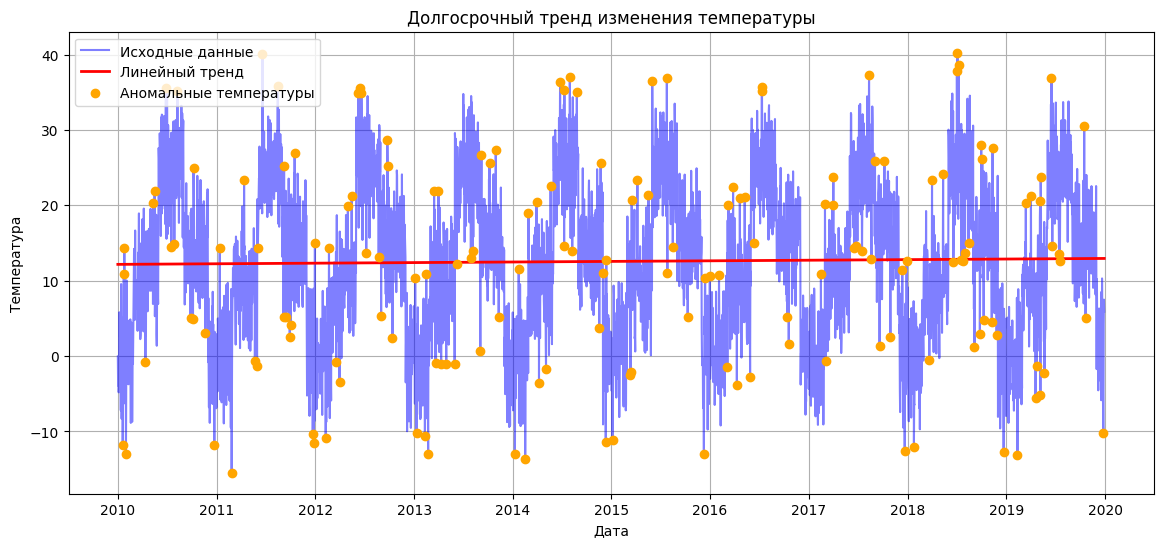

In [131]:
plot_results(temp_res)